In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiime2 import Artifact, Visualization
from scipy.stats import spearmanr, kruskal, pearsonr

%matplotlib inline

In [2]:
cd ../200608_Elsayed_Lowry-1101/reanalysis-2/

/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101/reanalysis-2


In [3]:
cp ../insertion-tree.qza insertion-tree.qza

In [4]:
ls

ANCOM-L2-chemo.qzv                  lefse_cesd_in.tsv
ANCOM-L6-chemo.qzv                  lefse_cesd_out.lefse_internal_res
CESD-LEfSe.pdf                      lefse_cesd_plotdata.csv
Chemo-LEfSe.pdf                     lefse_chemo_in.tsv
Figures/                            lefse_chemo_out.lefse_internal_res
L2-nobloom-pseudo-table.qza         lefse_chemo_plotdata.csv
L2-nobloom-table.qza                lefse_fact_in.tsv
L6-nobloom-pseudo-table.qza         lefse_fact_out.lefse_internal_res
L6-nobloom-table.qza                nobloom_metadata.tsv
clr_transformed_phyla.csv           nobloom_table.qza
core-diversity-results/             nobloom_table.qzv
diversity-stats-results/            samp-filt-seq-table.qza
expr-group-metadata.tsv             shared-scatterplot-LEfSe.pdf
filt-seq-taxa-barplot.qzv           taxonomy-gg.qza
insertion-tree.qza


# Diversity
### Start by looking at reads/feature

>qiime feature-table summarize \
--i-table nobloom_table.qza \
--o-visualization nobloom_table.qzv \

In [5]:
viz = Visualization.load("nobloom_table.qzv")
viz

<visualization: Visualization uuid: 7af54aa8-f056-4148-abd7-d5b1249ab6be>

**The lowest number of reads above 10,000 is 13,056, so I will rarefy to 13,055.**

>qiime diversity core-metrics-phylogenetic \
--i-table nobloom_table.qza \
--i-phylogeny insertion-tree.qza \
--p-sampling-depth 13055 \
--m-metadata-file nobloom_metadata.tsv \
--output-dir core-diversity-results/

In [6]:
mkdir diversity-stats-results/

mkdir: diversity-stats-results/: File exists


>qiime diversity alpha-group-significance \
--i-alpha-diversity core-diversity-results/faith_pd_vector.qza \
--m-metadata-file nobloom_metadata.tsv \
--o-visualization diversity-stats-results/faith-group.qzv

In [7]:
Visualization.load("diversity-stats-results/faith-group.qzv")

<visualization: Visualization uuid: 148091e8-02fa-4218-a49e-1628f2e9db89>

### Alpha group results
 - Chemotherapy
     - Not significant
     - p=0.267
     - H=1.23
 - CES-D
     - Not significant
     - p=0.091
     - H=2.86
 - FACT-Cog
     - Not significant
     - p=0.110
     - H=2.453
 - Stress scale
     - Not significant
     - p=0.498
     - H=0.458
 - PROMIS
     - Not significant
     - p=0.620
     - H=0.957

>qiime diversity alpha-correlation \
--i-alpha-diversity core-diversity-results/faith_pd_vector.qza \
--m-metadata-file nobloom_metadata.tsv \
--o-visualization diversity-stats-results/faith-corr.qzv

In [8]:
Visualization.load("diversity-stats-results/faith-corr.qzv")

<visualization: Visualization uuid: 7c5dc032-b053-449d-9906-83f471760e58>

### Alpha Correlation results
 - Time difference
     - Not significant
     - p=0.085
     - Spearman r = 0.510
 - CES-D Total
     - SIGNIFICANT
     - p=0.033
     - Spearman r = -0.3903
 - FACT-Cog total
     - Not significant
     - p=0.116
     - Spearman r=0.2929
 - Stress scale
     - Not significant
     - p=0.247
     - Spearman r = -0.2182
 - PROMIS
     - Not significant
     - p=0.0648
     - Spearman r = -0.3414


In [9]:
metadata = pd.read_csv("nobloom_metadata.tsv", sep="\t", index_col="sampleid")

faith = Artifact.load("core-diversity-results/faith_pd_vector.qza").view(pd.Series)
faith.index = faith.index.astype(int)

time_faith = pd.concat([ faith, 
                         metadata[["Chemotherapy", "Time difference"]] ], 
                       axis=1)

#Make controls time diff=0, get rid of negative time diff
time_faith.loc[time_faith["Chemotherapy"]=="Healthy Control", "Time difference"] = 0

time_faith.loc[(time_faith["Chemotherapy"]=="Breast Cancer") & 
               (time_faith["Time difference"] < 0),
                 "Time difference"] = np.NaN

#Drop nan faith values
time_faith.dropna(inplace=True)

time_faith_bc = time_faith[time_faith["Chemotherapy"]=="Breast Cancer"]

In [10]:
fit = np.polyfit(x = np.log(time_faith_bc["Time difference"]+0.01),
                 y = time_faith_bc["faith_pd"],
                 deg=1)

In [11]:
mkdir Figures

mkdir: Figures: File exists


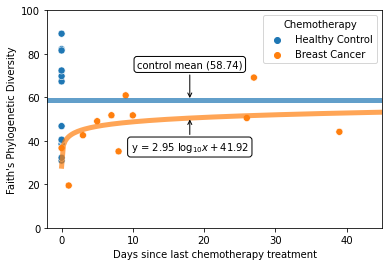

In [12]:
x = np.arange(0,45,0.25)+0.01
logy = fit[0] * np.log(x) + fit[1]


ax = sns.scatterplot(y="faith_pd",
                     x="Time difference",
                     data=time_faith,
                     hue="Chemotherapy",
                     x_jitter=True,
                     s=50)

ax.axhline(time_faith.loc[time_faith["Chemotherapy"]=="Healthy Control","faith_pd"].mean(),
           c="tab:blue",
           lw=5,
           alpha=0.7)

ax.plot(x,logy, lw=5, alpha=0.7, c="tab:orange")



annot_coords = (18, fit[0] * np.log(20) + fit[1])

ax.annotate("y = " + str(round(fit[0],2)) + r" $\log{_{10}}{x} + $" + str(round(fit[1], 2)), 
            xy=annot_coords, xytext=(18, fit[0] * np.log(20) + fit[1]-15),
            ha="center", bbox=dict(boxstyle="round", fc="w"),
            arrowprops=dict(arrowstyle="->"))

grp2_mean = time_faith.loc[time_faith["Chemotherapy"]=="Healthy Control","faith_pd"].mean()

ax.annotate("control mean (" + str(round(grp2_mean,2)) + ")", 
            xy=(18, grp2_mean), 
            xytext=(18, grp2_mean + 15),
            ha="center", bbox=dict(boxstyle="round", fc="w"),
            arrowprops=dict(arrowstyle="->"))

ax.set_ylim(0,100)
ax.set_xlim(-2,45)
ax.set_ylabel("Faith's Phylogenetic Diversity")
ax.set_xlabel("Days since last chemotherapy treatment")

plt.savefig("Figures/faith_log_fit_annotated.pdf")
plt.show()

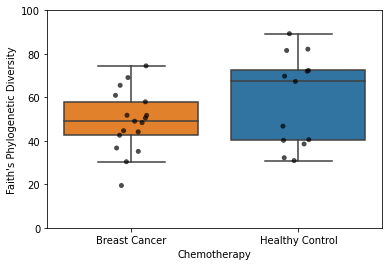

In [13]:
ax = sns.boxplot(x=metadata["Chemotherapy"],
                 y=faith,
                 showfliers=False,
                 palette=["tab:orange", "tab:blue"])

sns.stripplot(x=metadata["Chemotherapy"],
              y=faith,
              palette=["black"]*2,
              alpha=0.7)

ax.set_ylim(0,100)
ax.set_ylabel("Faith's Phylogenetic Diversity")

plt.savefig("Figures/faith_chemo.pdf")
plt.show()

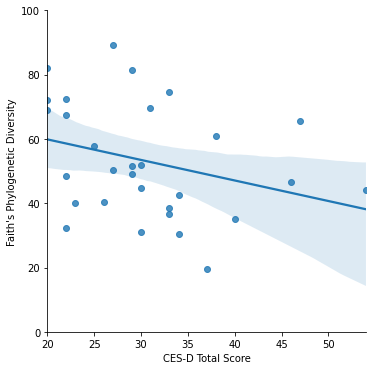

In [14]:
g = sns.lmplot(x="cesd_total",
                y="faith_pd",
                data=pd.concat([faith, metadata["cesd_total"]],
                              axis=1))

g.axes[0,0].set_ylim(0,100)
g.axes[0,0].set_ylabel("Faith's Phylogenetic Diversity")

g.axes[0,0].set_xlabel("CES-D Total Score")

plt.savefig("Figures/faith_cesd_corr.pdf")
plt.show()

### Beta Diversity

In [15]:
from skbio.stats.distance import mantel, permanova, DistanceMatrix
from scipy.spatial.distance import pdist, cdist

In [16]:
wuni = Artifact.load("core-diversity-results/weighted_unifrac_distance_matrix.qza").view(DistanceMatrix)
uuni = Artifact.load("core-diversity-results/unweighted_unifrac_distance_matrix.qza").view(DistanceMatrix)

In [17]:
metadata_beta = metadata
metadata_beta.index = metadata_beta.index.astype(str)
metadata_beta = metadata_beta.loc[list(wuni.ids)]

### PERMANOVA
#### Weighted UniFrac

In [18]:
for var in ["Chemotherapy", 
            "fact_c_r_imp_total_categorical",
            "stress_scale_total_categorical", 
            "cesd_total_categorical",
            "promis_tscore_categorical"]:
    perm = permanova(wuni, 
                    metadata_beta,
                    column=var)
    
    print("\n" + var)
    if perm[5] <= 0.05:
        print(" SIGNIFICANT")
    print(perm)


Chemotherapy
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic             0.816605
p-value                        0.54
number of permutations          999
Name: PERMANOVA results, dtype: object

fact_c_r_imp_total_categorical
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic              1.12314
p-value                       0.329
number of permutations          999
Name: PERMANOVA results, dtype: object

stress_scale_total_categorical
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic             0.396761
p-value                        0.97
number of permutations          999
Name: PERMANOVA results, dtype: object

cesd_total_categorical
method name              

#### Unweighted UniFrac

In [19]:
for var in ["Chemotherapy", 
            "fact_c_r_imp_total_categorical",
            "stress_scale_total_categorical", 
            "cesd_total_categorical",
            "promis_tscore_categorical"]:
    perm = permanova(uuni, 
                    metadata_beta,
                    column=var)
    
    print("\n" + var)
    if perm[5] <= 0.05:
        print("**SIGNIFICANT**")
    print(perm)


Chemotherapy
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic              1.07811
p-value                       0.246
number of permutations          999
Name: PERMANOVA results, dtype: object

fact_c_r_imp_total_categorical
**SIGNIFICANT**
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic              1.51465
p-value                       0.011
number of permutations          999
Name: PERMANOVA results, dtype: object

stress_scale_total_categorical
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic              0.80454
p-value                       0.916
number of permutations          999
Name: PERMANOVA results, dtype: object

cesd_total_categorical
method na

### Mantel
#### weighted UniFrac

In [20]:
for var in ["Time difference",
            "fact_c_total",
            "cesd_total",
            "promis_rawscore",
            "stress_scale_total"]:
    
    #initialize empty distance matrix
    dat = metadata_beta[var].dropna()
    dim = dat.shape[0]
    distm = np.empty((dim, dim))
    
    #fill distance matrix
    for i in range(dim):
        for j in range(dim):
            distm[i,j] = np.abs(dat.iloc[i]-dat.iloc[j])

    distm = DistanceMatrix(distm, ids=dat.index)

    #filter where we don't have data
    var_wuni = DistanceMatrix(wuni.to_data_frame().loc[dat.index,dat.index], 
                              ids=dat.index)
    #do the mantel
    man = mantel(var_wuni, 
                distm,
                method="spearman")

    print("\nvariable: ", var)
    print("significant: ", man[1]<0.05)
    print("corr coef: ", man[0])
    print("p value: ", man[1])


variable:  Time difference
significant:  False
corr coef:  0.15358421848850945
p value:  0.448

variable:  fact_c_total
significant:  False
corr coef:  0.002951707445232093
p value:  0.974

variable:  cesd_total
significant:  False
corr coef:  0.06348284364350958
p value:  0.462

variable:  promis_rawscore
significant:  False
corr coef:  -0.09411761358093827
p value:  0.276

variable:  stress_scale_total
significant:  False
corr coef:  -0.07729954779591705
p value:  0.217


#### Unweighted UniFrac

In [21]:
for var in ["Time difference",
            "fact_c_total",
            "cesd_total",
            "promis_rawscore",
            "stress_scale_total"]:
    
    #initialize empty distance matrix
    dat = metadata_beta[var].dropna()
    dim = dat.shape[0]
    distm = np.empty((dim, dim))
    
    #fill distance matrix
    for i in range(dim):
        for j in range(dim):
            distm[i,j] = np.abs(dat.iloc[i]-dat.iloc[j])

    distm = DistanceMatrix(distm, ids=dat.index)

    #filter where we don't have data
    var_uuni = DistanceMatrix(uuni.to_data_frame().loc[dat.index,dat.index], 
                              ids=dat.index)
    #do the mantel
    man = mantel(var_uuni, 
                distm,
                method="spearman")

    print("\nvariable: ", var)
    print("significant: ", man[1]<0.05)
    print("corr coef: ", man[0])
    print("p value: ", man[1])


variable:  Time difference
significant:  False
corr coef:  0.07642638277486448
p value:  0.647

variable:  fact_c_total
significant:  False
corr coef:  0.10572806820942689
p value:  0.17

variable:  cesd_total
significant:  False
corr coef:  0.0008239026282835701
p value:  0.996

variable:  promis_rawscore
significant:  False
corr coef:  0.01658151414238586
p value:  0.855

variable:  stress_scale_total
significant:  False
corr coef:  -0.03324645393547799
p value:  0.615


## Differential abundance

! qiime taxa collapse \
--i-table nobloom_table.qza \
--i-taxonomy taxonomy-gg.qza \
--p-level 2 \
--o-collapsed-table L2-nobloom-table.qza

! qiime taxa collapse \
--i-table nobloom_table.qza \
--i-taxonomy taxonomy-gg.qza \
--p-level 6 \
--o-collapsed-table L6-nobloom-table.qza

! qiime composition add-pseudocount \
--i-table L2-nobloom-table.qza \
--o-composition-table L2-nobloom-pseudo-table.qza

! qiime composition add-pseudocount \
--i-table L6-nobloom-table.qza \
--o-composition-table L6-nobloom-pseudo-table.qza

! qiime composition ancom \
--i-table L2-nobloom-pseudo-table.qza \
--m-metadata-file nobloom_metadata.tsv \
--m-metadata-column "Chemotherapy" \
--o-visualization ANCOM-L2-chemo.qzv

! qiime composition ancom \
--i-table L6-nobloom-pseudo-table.qza \
--m-metadata-file nobloom_metadata.tsv \
--m-metadata-column "Chemotherapy" \
--o-visualization ANCOM-L6-chemo.qzv

#### NO SIGNIFICANT RESULTS FROM ANCOM

### Taxa correlations

In [22]:
L2 = Artifact.load("L2-nobloom-table.qza").view(pd.DataFrame)

L2mat = np.matrix(L2)
L2mat /= L2mat.sum(axis=1)

L2 = pd.DataFrame(L2mat,
                  columns=L2.columns,
                  index=L2.index)

In [59]:
print("SPEARMAN CORR PHYLA AND FACT COG")
for col in L2.columns:
    spear = spearmanr(metadata["fact_c_total"].reindex_like(L2),
                      L2[col])
    
    if spear.pvalue < 0.05:
        print("SIGNIFICANT:")
    print(col, spear)

SPEARMAN CORR PHYLA AND FACT COG
k__Archaea;p__Euryarchaeota SpearmanrResult(correlation=-0.003013447239978311, pvalue=0.9869404736606391)
k__Bacteria;__ SpearmanrResult(correlation=-0.13930389624955528, pvalue=0.4470223155634683)
k__Bacteria;p__ SpearmanrResult(correlation=-0.033858061155492905, pvalue=0.8540429284168896)
k__Bacteria;p__Actinobacteria SpearmanrResult(correlation=0.10506051311441914, pvalue=0.5671497203375993)
k__Bacteria;p__Bacteroidetes SpearmanrResult(correlation=-0.010634397488021483, pvalue=0.9539355419484379)
k__Bacteria;p__Cyanobacteria SpearmanrResult(correlation=-0.1909538786386009, pvalue=0.2951486984983393)
k__Bacteria;p__Firmicutes SpearmanrResult(correlation=-0.03355335759151606, pvalue=0.8553426439957798)
k__Bacteria;p__Fusobacteria SpearmanrResult(correlation=0.09371037571423518, pvalue=0.6099532669062211)
k__Bacteria;p__Lentisphaerae SpearmanrResult(correlation=0.29686791960883524, pvalue=0.09895101876710606)
k__Bacteria;p__Proteobacteria SpearmanrResul

In [60]:
print("SPEARMAN CORR PHYLA AND CESD")
for col in L2.columns:
    spear = spearmanr(metadata["cesd_total"].reindex_like(L2),
                      L2[col])
    
    if spear.pvalue < 0.05:
        print("SIGNIFICANT:")
    print(col, spear)

SPEARMAN CORR PHYLA AND CESD
k__Archaea;p__Euryarchaeota SpearmanrResult(correlation=-0.0024160815182863622, pvalue=0.9895291487495608)
k__Bacteria;__ SpearmanrResult(correlation=-0.11408024378813332, pvalue=0.5341424498562868)
k__Bacteria;p__ SpearmanrResult(correlation=0.02517597109949954, pvalue=0.8912109567792014)
k__Bacteria;p__Actinobacteria SpearmanrResult(correlation=-0.04336655291250909, pvalue=0.8136897177164872)
k__Bacteria;p__Bacteroidetes SpearmanrResult(correlation=0.17328245506989862, pvalue=0.34290782900065586)
k__Bacteria;p__Cyanobacteria SpearmanrResult(correlation=-0.1846565691684659, pvalue=0.31165737142123756)
k__Bacteria;p__Firmicutes SpearmanrResult(correlation=-0.11429659284568074, pvalue=0.5333621938049486)
k__Bacteria;p__Fusobacteria SpearmanrResult(correlation=0.0529790000528599, pvalue=0.773367344351273)
k__Bacteria;p__Lentisphaerae SpearmanrResult(correlation=-0.1580253017607068, pvalue=0.3876941652995556)
k__Bacteria;p__Proteobacteria SpearmanrResult(corre

UNTRANSFORMED HISTOGRAMS


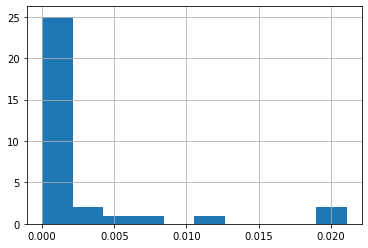

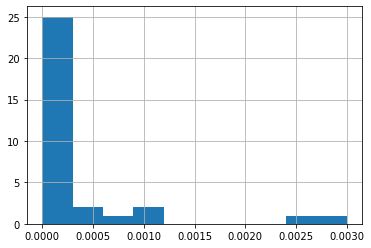

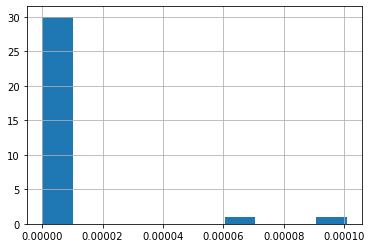

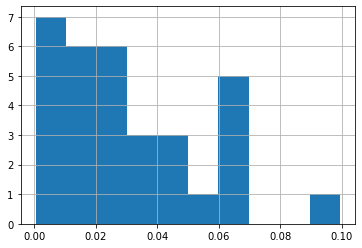

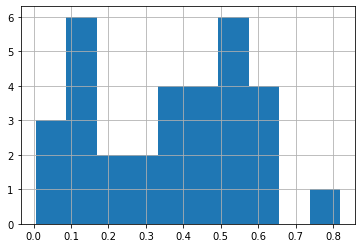

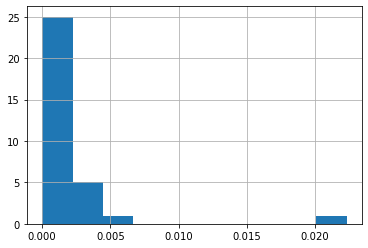

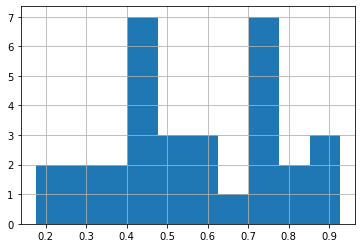

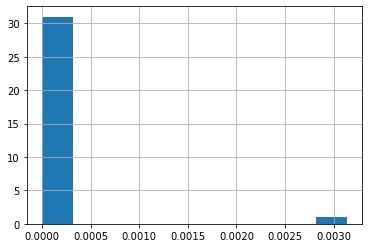

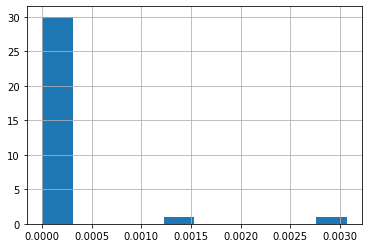

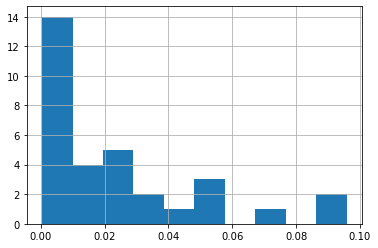

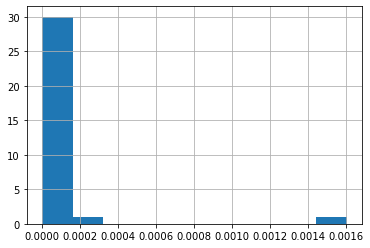

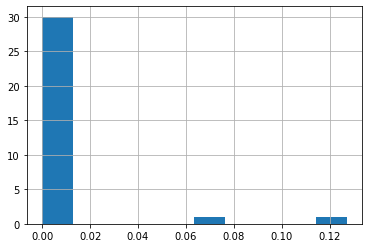

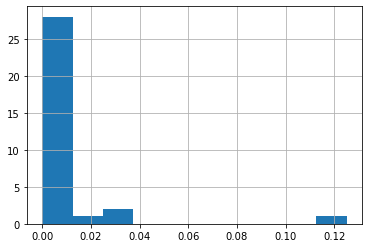

In [25]:
print("UNTRANSFORMED HISTOGRAMS")
for col in L2.columns:
    L2[col].hist()
    plt.show()

In [26]:
from skbio.stats.composition import clr

In [58]:
print("PEARSON CORR PHYLA AND FACT-COG")
for col in L2.columns:
    r, p = pearsonr(metadata["fact_c_total"].reindex_like(L2),
                      clr(L2[col].apply(lambda x: x+0.00001)))
    
    if p < 0.05:
        print("SIGNIFICANT:")
    print(col, r, p)

PEARSON CORR PHYLA AND FACT-COG
k__Archaea;p__Euryarchaeota 0.034368191494453984 0.8518678061672841
k__Bacteria;__ -0.11730220908944226 0.5225794380283644
k__Bacteria;p__ 0.01647736927610054 0.9286785625232692
k__Bacteria;p__Actinobacteria 0.02171587505360653 0.9060915819671096
k__Bacteria;p__Bacteroidetes 0.0221714093950979 0.9041305944472732
k__Bacteria;p__Cyanobacteria -0.29923296699603563 0.0961643105807507
k__Bacteria;p__Firmicutes 0.12351626096813473 0.5006287759225702
k__Bacteria;p__Fusobacteria 0.16314026006158164 0.3723170084623345
k__Bacteria;p__Lentisphaerae 0.28815666624282477 0.10974479088587293
k__Bacteria;p__Proteobacteria -0.02856994994494097 0.8766498879663186
k__Bacteria;p__Synergistetes 0.0531834176285564 0.7725157263605427
k__Bacteria;p__Tenericutes 0.31514544833479813 0.07893747578444758
k__Bacteria;p__Verrucomicrobia 0.26756172572034076 0.13874389953049177


In [61]:
print("PEARSON CORR PHYLA AND CESD")
for col in L2.columns:
    r, p = pearsonr(metadata["cesd_total"].reindex_like(L2),
                      clr(L2[col].apply(lambda x: x+0.00001)))
    
    if p < 0.05:
        print("SIGNIFICANT:")
    print(col, r, p)

PEARSON CORR PHYLA AND CESD
k__Archaea;p__Euryarchaeota 0.1192210176595688 0.5157516975033499
k__Bacteria;__ -0.03490369812245231 0.8495856331976083
k__Bacteria;p__ -0.0011794590103269623 0.9948883363351921
k__Bacteria;p__Actinobacteria 0.004014273985706387 0.9826037119506041
k__Bacteria;p__Bacteroidetes -0.06423587426869044 0.7268814432963026
k__Bacteria;p__Cyanobacteria -0.17331096846589983 0.3428271916142132
k__Bacteria;p__Firmicutes -0.06256936383435548 0.7337079467559613
k__Bacteria;p__Fusobacteria -0.0038378548064915783 0.9833681359251001
k__Bacteria;p__Lentisphaerae -0.16803554269409696 0.35794175856118526
k__Bacteria;p__Proteobacteria -0.08020394994670843 0.6625789988913344
k__Bacteria;p__Synergistetes -0.13838636197264273 0.4500502562024056
SIGNIFICANT:
k__Bacteria;p__Tenericutes -0.4643557834541515 0.007420972443826028
k__Bacteria;p__Verrucomicrobia -0.18009518588508625 0.32396876596846796


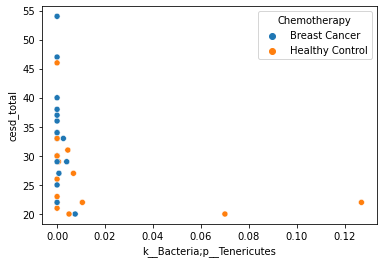

In [69]:
ax = sns.scatterplot(x=L2["k__Bacteria;p__Tenericutes"],
                    y=metadata["cesd_total"].reindex_like(L2),
                    hue=metadata["Chemotherapy"])

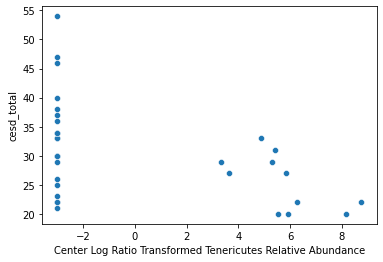

In [72]:
ax = sns.scatterplot(x=pd.Series(clr(L2["k__Bacteria;p__Tenericutes"].apply(lambda x: x+0.000001)), index=L2.index),
                    y=metadata["cesd_total"].reindex_like(L2),
#                    hue=metadata["Chemotherapy"]
                    )

ax.set_xlabel("Center Log Ratio Transformed Tenericutes Relative Abundance")
plt.show()

CLR TRANSFORMED HISTOGRAMS
k__Archaea;p__Euryarchaeota


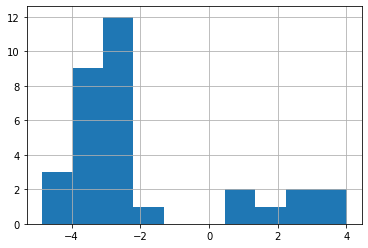

k__Bacteria;__


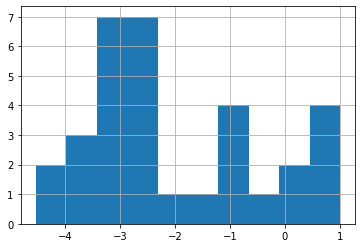

k__Bacteria;p__


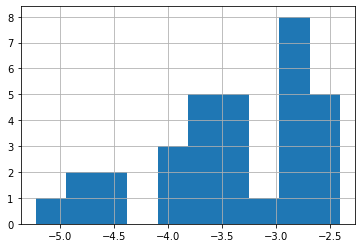

k__Bacteria;p__Actinobacteria


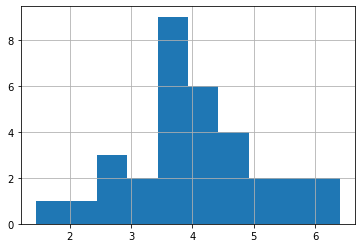

k__Bacteria;p__Bacteroidetes


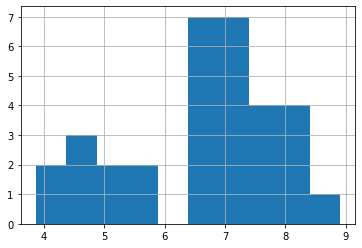

k__Bacteria;p__Cyanobacteria


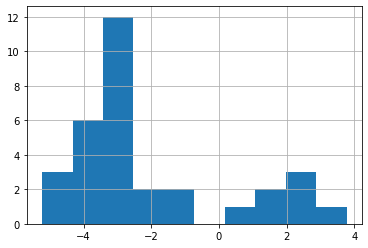

k__Bacteria;p__Firmicutes


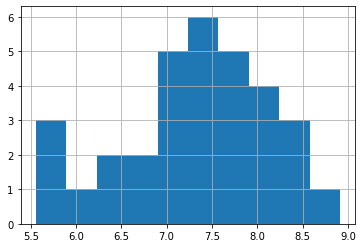

k__Bacteria;p__Fusobacteria


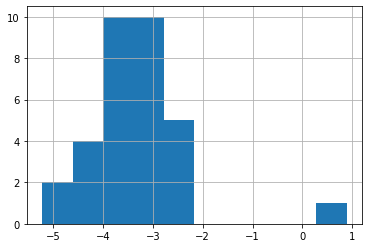

k__Bacteria;p__Lentisphaerae


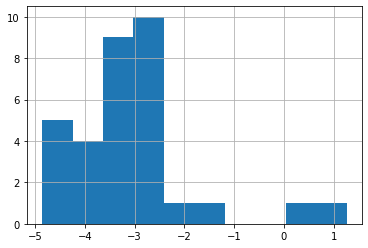

k__Bacteria;p__Proteobacteria


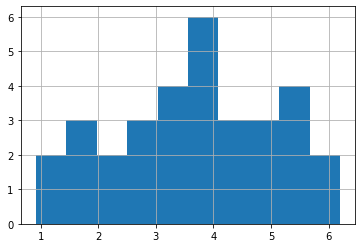

k__Bacteria;p__Synergistetes


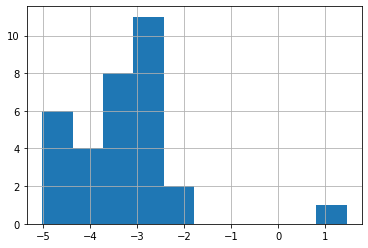

k__Bacteria;p__Tenericutes


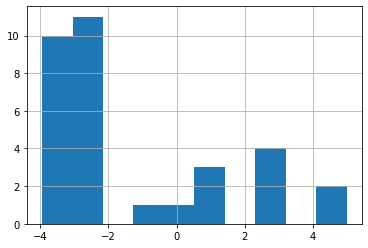

k__Bacteria;p__Verrucomicrobia


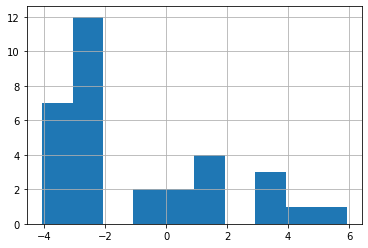

In [29]:
clr_L2 = pd.DataFrame(clr(L2.apply(lambda x: x+0.00001)),
                     index=L2.index,
                     columns=L2.columns)

clr_L2["participant ID"] = metadata["plate.sample.id"].apply(lambda x: x.split("-")[0])
clr_L2 = clr_L2.reset_index().set_index("participant ID")
clr_L2 = clr_L2.rename(columns={"index":"SampleID"})

clr_L2.to_csv("clr_transformed_phyla.csv")

print("CLR TRANSFORMED HISTOGRAMS")
for col in clr_L2.drop("SampleID",axis=1):
    print(col)
    clr_L2[col].hist()
    plt.show()

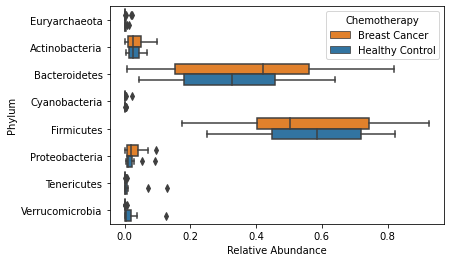

In [30]:
L2chemo = pd.concat([L2.loc[:,L2.mean(axis=0)>0.001], 
                     metadata["Chemotherapy"]],
                    axis=1)

L2chemo = pd.melt(L2chemo, id_vars="Chemotherapy")

L2chemo["Phylum"] = L2chemo["variable"].apply(lambda x: x.split("p__")[1])

ax = sns.boxplot(x="value",
                y="Phylum",
                hue="Chemotherapy",
                data=L2chemo,
                palette=["tab:orange","tab:blue"])

ax.set_xlabel("Relative Abundance")

plt.savefig("Figures/Phyla-boxplots.pdf")
plt.show()

### Akkermansia

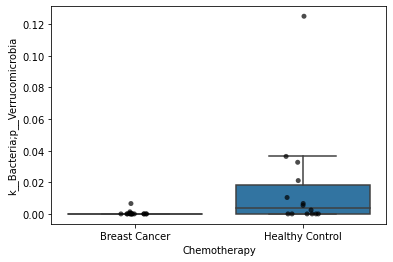

In [31]:
ax = sns.boxplot(x=metadata["Chemotherapy"],
                y=L2["k__Bacteria;p__Verrucomicrobia"],
                showfliers=False,
                 palette=["tab:orange", "tab:blue"])

sns.stripplot(x=metadata["Chemotherapy"],
              y=L2["k__Bacteria;p__Verrucomicrobia"],
              palette=["black"]*2,
              alpha=0.7,
              ax=ax)
plt.show()

In [32]:
kruskal(L2.loc[metadata["Chemotherapy"]=="Breast Cancer","k__Bacteria;p__Verrucomicrobia"],
        L2.loc[metadata["Chemotherapy"]=="Healthy Control","k__Bacteria;p__Verrucomicrobia"])

KruskalResult(statistic=5.518042867440461, pvalue=0.01882130426578598)

In [33]:
L6 = Artifact.load("L6-nobloom-table.qza").view(pd.DataFrame)

L6mat = np.matrix(L6)
L6mat /= L6mat.sum(axis=1)

L6 = pd.DataFrame(L6mat,
                  columns=L6.columns,
                  index=L6.index)

In [34]:
list(filter(lambda x: "akkermansia" in x.lower(), L6.columns))

['k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia']

In [35]:
akker = 'k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia'

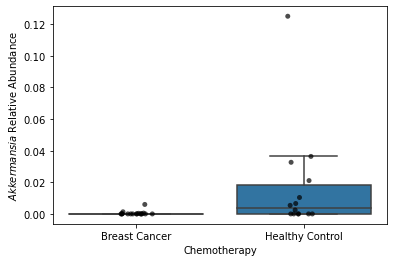

In [36]:
ax = sns.boxplot(x=metadata["Chemotherapy"],
                y=L6[akker],
                showfliers=False,
                palette=["tab:orange", "tab:blue"])

sns.stripplot(x=metadata["Chemotherapy"],
              y=L6[akker],
              palette=["black"]*2,
              alpha=0.7,
              ax=ax)

ax.set_ylabel(r"$Akkermansia$ Relative Abundance")

plt.savefig("Figures/Akkermansia-boxplot.pdf")
plt.show()

In [37]:
kruskal(L6.loc[metadata["Chemotherapy"]=="Breast Cancer",akker],
        L6.loc[metadata["Chemotherapy"]=="Healthy Control",akker])

KruskalResult(statistic=5.518042867440461, pvalue=0.01882130426578598)

### Chemo/Control Taxa correlations, per Emily's request

In [57]:
bcmap = {"Healthy Control":0, "Breast Cancer":1}

print("PEARSON CORR PHYLA AND CHEMO")
for col in L2.columns:
    r, p = pearsonr(pd.Series(clr(L2[col].apply(lambda x: x+0.00001)), index=L2.index),
                    metadata["Chemotherapy"].replace(bcmap).reindex_like(L2))
    
    if p < 0.05:
        print("SIGNIFICANT:")
    print(col, f"r: {r}, p: {p}")

PEARSON CORR PHYLA AND CHEMO
k__Archaea;p__Euryarchaeota r: -0.09709660234040693, p: 0.5970410685196886
k__Bacteria;__ r: 0.09210256619620677, p: 0.616124994333259
k__Bacteria;p__ r: 0.2266987421973002, p: 0.21214048247686765
k__Bacteria;p__Actinobacteria r: -0.12325377872011428, p: 0.5015464899714674
k__Bacteria;p__Bacteroidetes r: -0.004020738746921819, p: 0.982575700436164
k__Bacteria;p__Cyanobacteria r: 0.10736540279686742, p: 0.5586275619230582
k__Bacteria;p__Firmicutes r: -0.13413282358159717, p: 0.4642303481165677
k__Bacteria;p__Fusobacteria r: -0.12826422253920092, p: 0.48417555167754045
k__Bacteria;p__Lentisphaerae r: -0.20808904696388422, p: 0.25309631012127626
k__Bacteria;p__Proteobacteria r: 0.09598335617470212, p: 0.6012730202182178
k__Bacteria;p__Synergistetes r: 0.017327136484892022, p: 0.9250104336325986
k__Bacteria;p__Tenericutes r: -0.3407241149906237, p: 0.056354277356640364
SIGNIFICANT:
k__Bacteria;p__Verrucomicrobia r: -0.4530575951844207, p: 0.009215645275401151


In [52]:
from scipy.stats import ttest_ind

for col in L2.columns:
    clr_tax = pd.Series(clr(L2[col].apply(lambda x: x+0.00001)),index=L2.index)

    res = ttest_ind(clr_tax.loc[metadata["Chemotherapy"]=="Breast Cancer"],
                    clr_tax.loc[metadata["Chemotherapy"]=="Healthy Control"])

    if res.pvalue < 0.05:
        print("SIGNIFICANT:")
    print(col, f"test statistic: {res.statistic}, p: {res.pvalue}")

k__Archaea;p__Euryarchaeota test statistic: -0.5343447930876146, p: 0.597041068519689
k__Bacteria;__ test statistic: 0.5066199061494081, p: 0.6161249943332587
k__Bacteria;p__ test statistic: 1.2748715208822168, p: 0.21214048247686712
k__Bacteria;p__Actinobacteria test statistic: -0.680275726196357, p: 0.5015464899714671
k__Bacteria;p__Bacteroidetes test statistic: -0.022022671108955956, p: 0.9825757004361644
k__Bacteria;p__Cyanobacteria test statistic: 0.5914835244071432, p: 0.5586275619230578
k__Bacteria;p__Firmicutes test statistic: -0.7413752714213778, p: 0.4642303481165667
k__Bacteria;p__Fusobacteria test statistic: -0.7083833041422567, p: 0.48417555167754
k__Bacteria;p__Lentisphaerae test statistic: -1.165258286992369, p: 0.25309631012127626
k__Bacteria;p__Proteobacteria test statistic: 0.5281610449591774, p: 0.601273020218217
k__Bacteria;p__Synergistetes test statistic: 0.09491888489930679, p: 0.9250104336325966
k__Bacteria;p__Tenericutes test statistic: -1.984998549998154, p: 0.

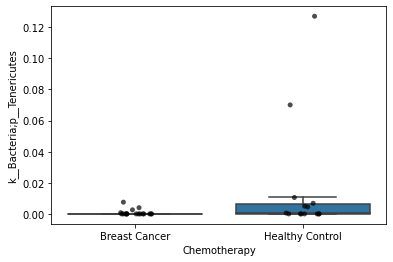

In [54]:
ax = sns.boxplot(x=metadata["Chemotherapy"],
                y=L2["k__Bacteria;p__Tenericutes"],
                showfliers=False,
                 palette=["tab:orange", "tab:blue"])

sns.stripplot(x=metadata["Chemotherapy"],
              y=L2["k__Bacteria;p__Tenericutes"],
              palette=["black"]*2,
              alpha=0.7,
              ax=ax)
plt.show()

# Export clr transformed phyla for Emily's hierarchical regression

In [74]:
L2_clr = pd.DataFrame(index=L2.index, columns=L2.columns)

for col in L2.columns:
    L2_clr[col] = clr(L2[col].apply(lambda x: x+0.000001))

In [79]:
L2_clr["Participant ID"] = metadata["plate.sample.id"].apply(lambda x: x.split("-")[0])

In [83]:
L2_clr.to_csv("clr_transformed_phyla.csv")